In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVC

%matplotlib inline

## Data Loading

In [2]:
df = pd.read_csv('train.csv')

In [3]:
df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
id                    1458644 non-null object
vendor_id             1458644 non-null int64
pickup_datetime       1458644 non-null object
dropoff_datetime      1458644 non-null object
passenger_count       1458644 non-null int64
pickup_longitude      1458644 non-null float64
pickup_latitude       1458644 non-null float64
dropoff_longitude     1458644 non-null float64
dropoff_latitude      1458644 non-null float64
store_and_fwd_flag    1458644 non-null object
trip_duration         1458644 non-null int64
dtypes: float64(4), int64(3), object(4)
memory usage: 122.4+ MB


## Data Exploration 

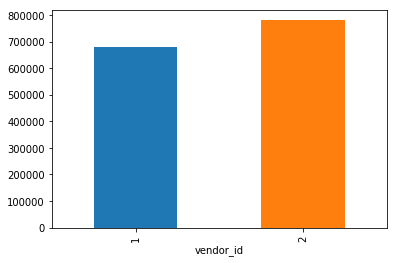

In [5]:
df.groupby('vendor_id').count()['id'].plot.bar()

In [6]:
one = df.groupby('vendor_id').count()['id'].iloc[0:1]
two = df.groupby('vendor_id').count()['id'].iloc[1:2]

print('Vendor_id 2 has received ' , np.subtract(two, one).values[0], 'more bookings then Vendor_id 1.')

Vendor_id 2 has received  101960 more bookings then Vendor_id 1.


/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


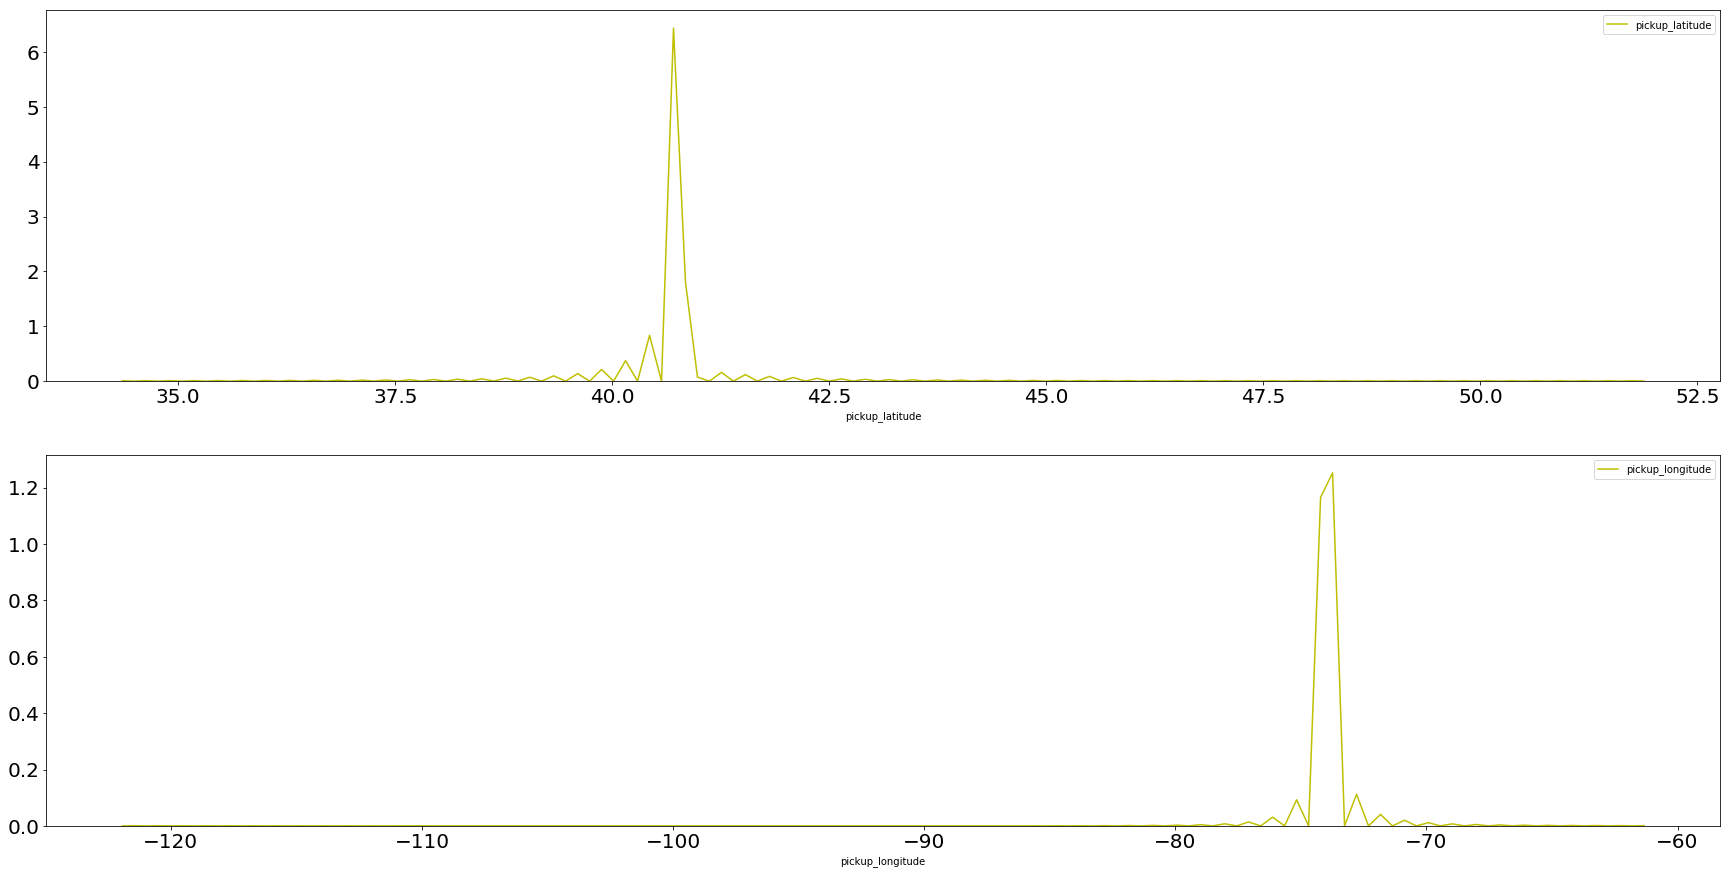

In [7]:
f, axes = plt.subplots(2,figsize=(30, 15), sharex=False, sharey = False)
sns.distplot(df['pickup_latitude'], label = 'pickup_latitude',color="y",bins = 100, ax=axes[0], hist=False).tick_params(labelsize=20)
sns.distplot(df['pickup_longitude'], label = 'pickup_longitude',color="y",bins =100, ax=axes[1], hist=False).tick_params(labelsize=20)

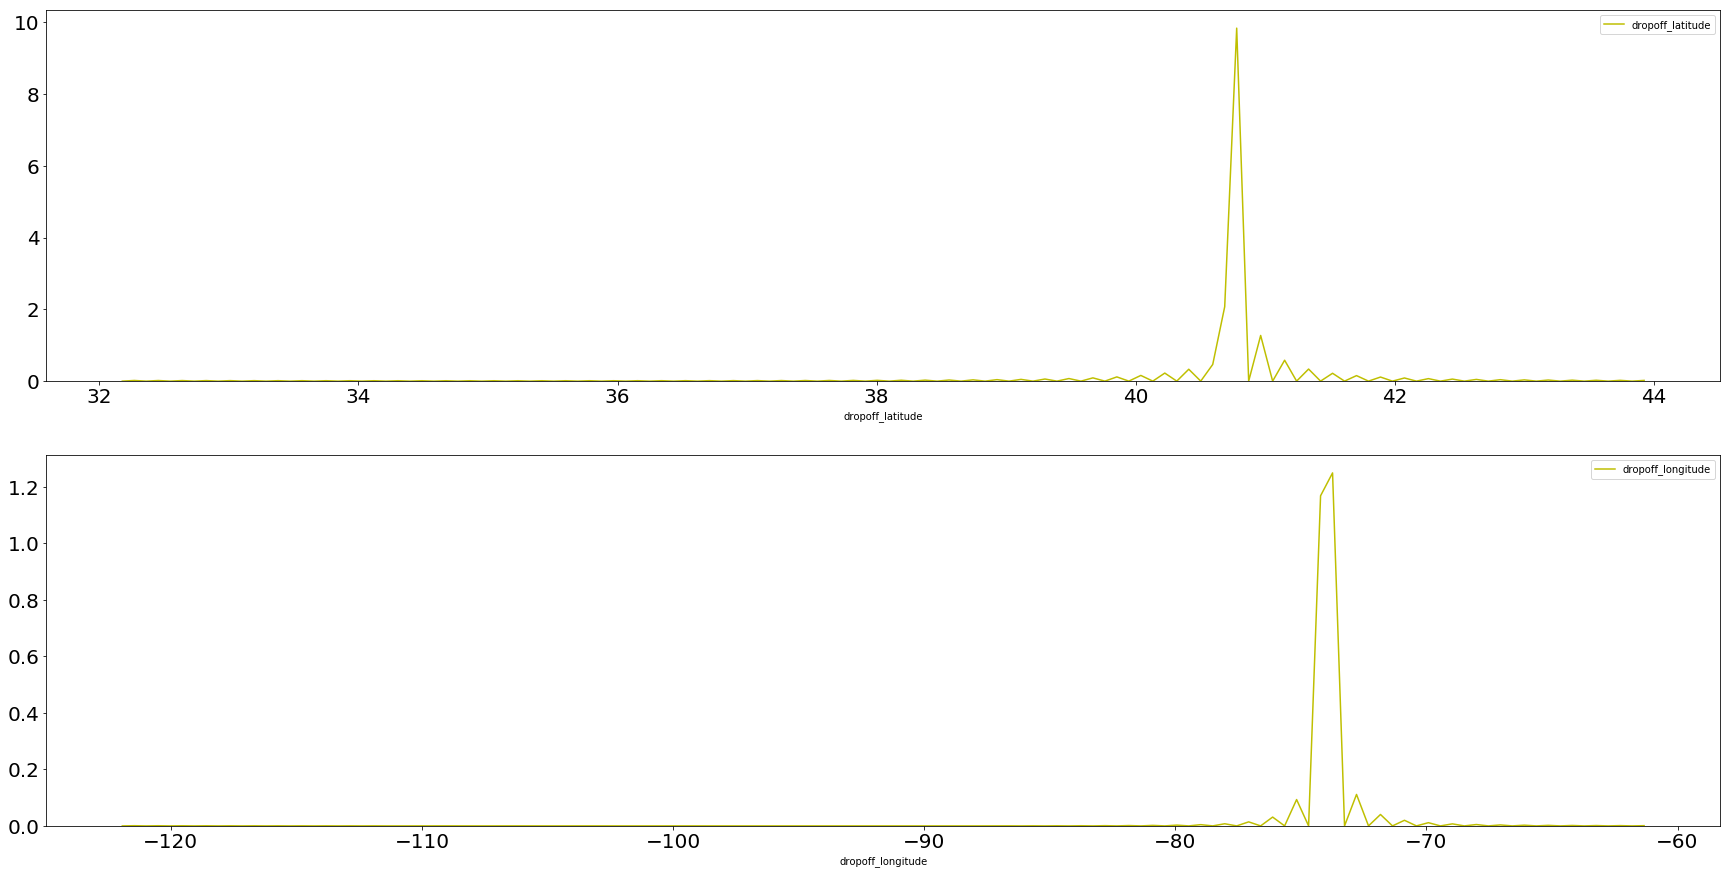

In [8]:
f, axes = plt.subplots(2,figsize=(30, 15), sharex=False, sharey = False)
sns.distplot(df['dropoff_latitude'], label = 'dropoff_latitude',color="y",bins = 100, ax=axes[0], hist=False).tick_params(labelsize=20)
sns.distplot(df['dropoff_longitude'], label = 'dropoff_longitude',color="y",bins =100, ax=axes[1], hist=False).tick_params(labelsize=20)

0.7085621988641505


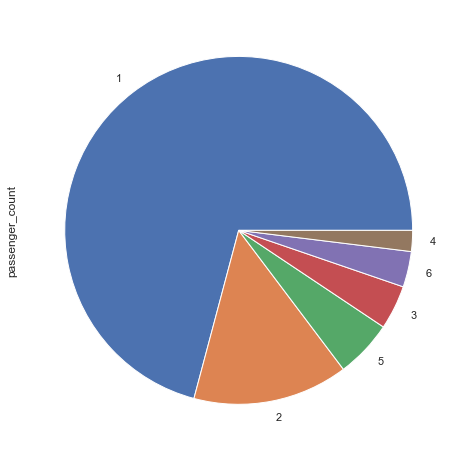

In [456]:
df['passenger_count'].value_counts()[0:6].plot(kind='pie', subplots=True, figsize=(8, 8))

passenger_1_percentage = df['passenger_count'].value_counts().values[0]/df['passenger_count'].count()
print(passenger_1_percentage)

70.86% of people travel by themselves.

## Data Preprocessing

In [11]:
df.isna().sum()

id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
dtype: int64

In [12]:
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])
df['dropoff_datetime'] = pd.to_datetime(df['dropoff_datetime'])

## Feature Engineering 

Travel distance based on dropoff and pickup locations: 

In [13]:
# approximate radius of earth in km
R = 6371.0

lat1 = np.radians(df['pickup_latitude'])
lon1 = np.radians(df['pickup_longitude'])
lat2 = np.radians(df['dropoff_latitude']) 
lon2 = np.radians(df['dropoff_longitude'])

dlon = lon2 - lon1
dlat = lat2 - lat1

a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

distance = R * c

distance_df = pd.DataFrame({'travel_distance_km':distance})

df['travel_distance_km'] = distance_df

np.mean(distance_df)

travel_distance_km    3.440864
dtype: float64

The average distance is 3.44km.

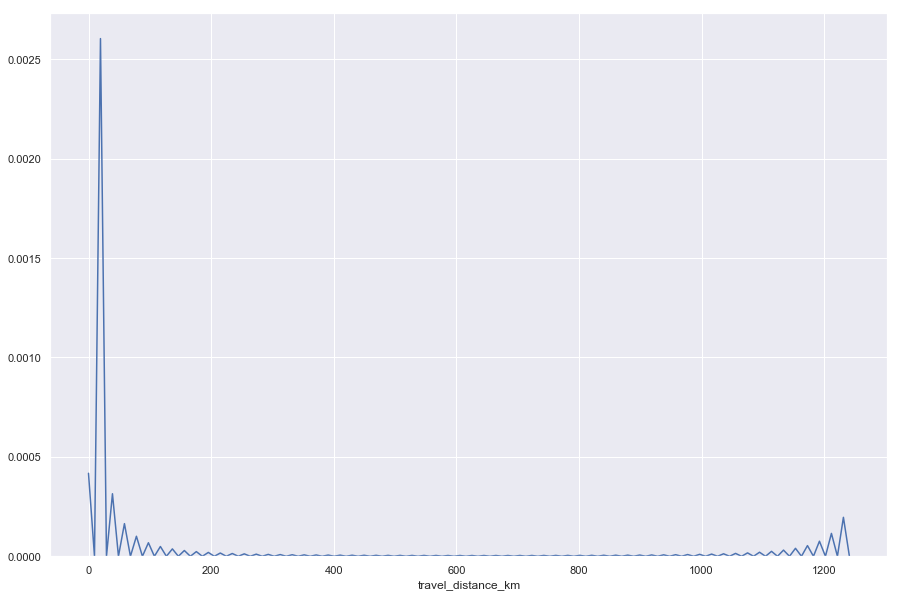

In [14]:
sns.set(rc={'figure.figsize':(15,10)})
sns.distplot(df['travel_distance_km'],hist=False)

This shows that most trips are between 0 and 200 km. Let's see what this means exactly: 

/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


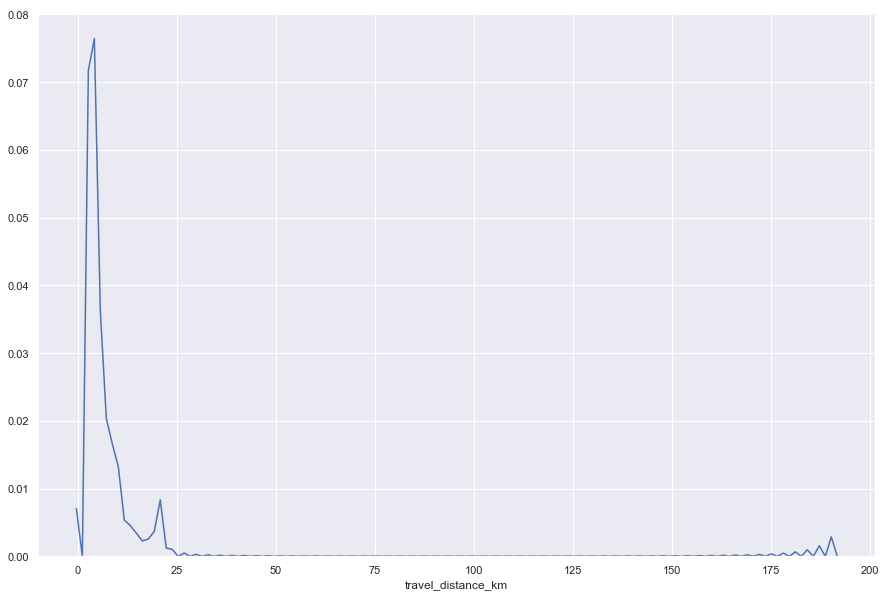

In [455]:
sns.distplot(df[ 
        (df['travel_distance_km'] >= 0) & 
        (df['travel_distance_km'] < 200)
                                        ]['travel_distance_km'],hist=False)

We can conclude that most trips are between 0 to 25 km. Let's zoom in one more time :

% of trips between 0 to 5 km for the trip distance between 0 to 25 km dataset :  0.8207250927776192


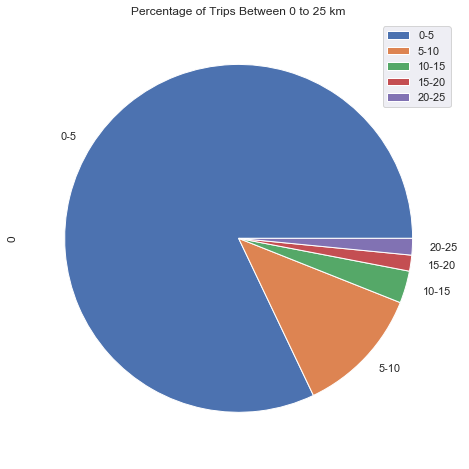

In [16]:
category_dict = {'0-5': 0,'5-10': 0, '10-15': 0, '15-20': 0, '20-25':0 }

for x in np.array(df[(df['travel_distance_km'] >= 0) & (df['travel_distance_km'] < 25)]['travel_distance_km']): 
    
    if x <= 5: 
        category_dict['0-5'] = category_dict['0-5'] + 1
        
    elif x > 5 and x <= 10 : 
        category_dict['5-10'] = category_dict['5-10'] + 1
    
    elif x > 10 and x <= 15 :
        category_dict['10-15'] = category_dict['10-15'] + 1

    elif x > 15 and x <= 20 :
        category_dict['15-20'] = category_dict['15-20'] + 1
    
    elif x > 20 and x <= 25 :
        category_dict['20-25'] = category_dict['20-25'] + 1
        
pd.DataFrame(category_dict, index=[0]).T.plot(kind='pie', subplots=True, figsize=(8, 8))
plt.title('Percentage of Trips Between 0 to 25 km')

print('% of trips between 0 to 5 km for the trip distance between 0 to 25 km dataset : ', category_dict['0-5']/sum(category_dict.values()))

- We can conclude that 82% of the trips are between 0 to 5 km only for the travel distance between 0 to 25 km. 

mode :  368
mean : 835.0637327899889
median : 661.0


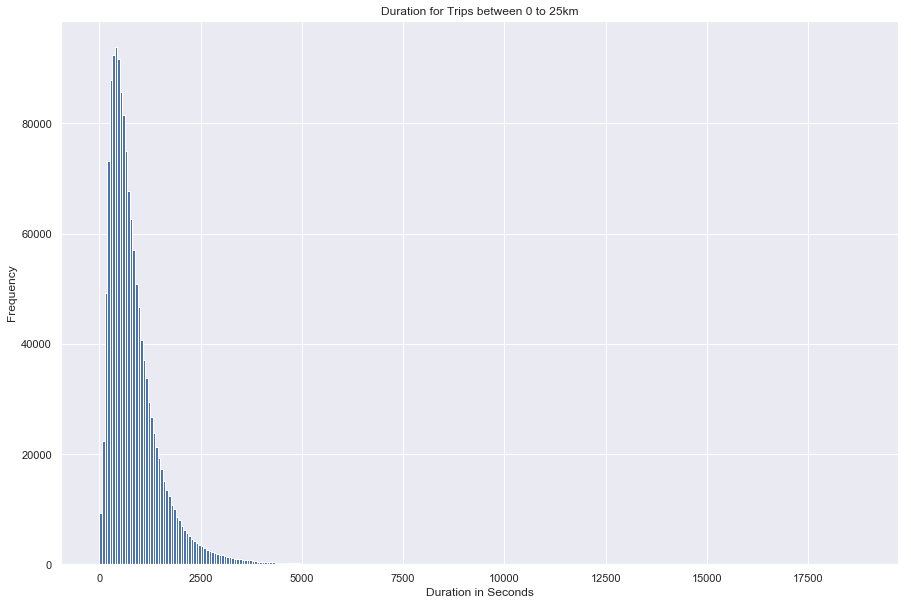

In [17]:
df[(df['travel_distance_km'] >= 0) & (df['travel_distance_km'] < 25) & (df['trip_duration'] < 20000) ]['trip_duration'].hist(bins=300)

plt.title('Duration for Trips between 0 to 25km')
plt.xlabel('Duration in Seconds')
plt.ylabel('Frequency')

print('mode : ', df[(df['travel_distance_km'] >= 0) & (df['travel_distance_km'] < 25) & (df['trip_duration'] < 20000) ]['trip_duration'].mode()[0])
print('mean :' , df[(df['travel_distance_km'] >= 0) & (df['travel_distance_km'] < 25) & (df['trip_duration'] < 20000) ]['trip_duration'].mean())
print('median :' , df[(df['travel_distance_km'] >= 0) & (df['travel_distance_km'] < 25) & (df['trip_duration'] < 20000) ]['trip_duration'].median())


This is a distribution of the duration for trips only between 0 to 25 km. As we can clearly see, the distribution is skewed to the right.

Below is the log distribution including the outliers.

Text(0, 0.5, 'Frequency')

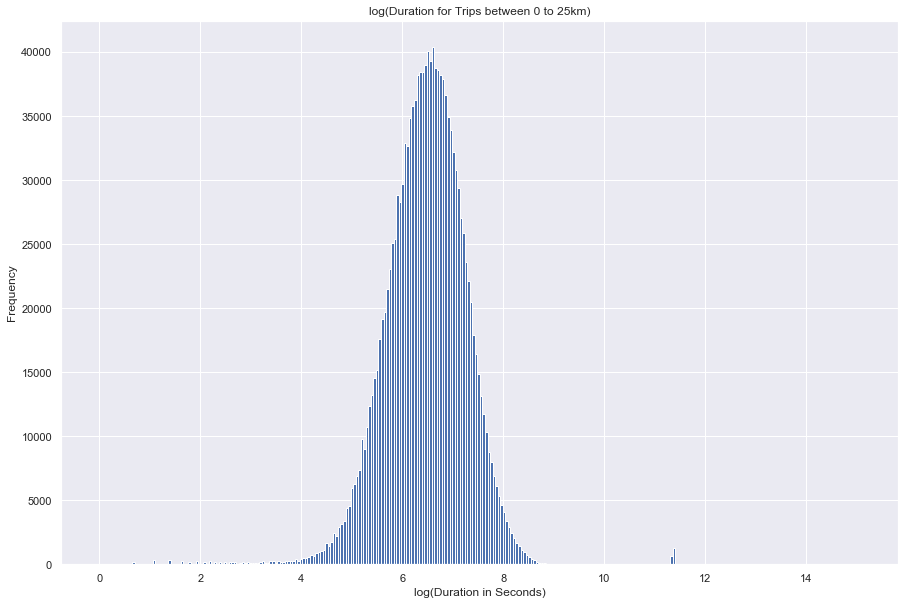

In [18]:
np.log(df[(df['travel_distance_km'] >= 0) & (df['travel_distance_km'] < 25)]['trip_duration']).plot.hist(bins=300)
plt.title('log(Duration for Trips between 0 to 25km)')
plt.xlabel('log(Duration in Seconds)')
plt.ylabel('Frequency')

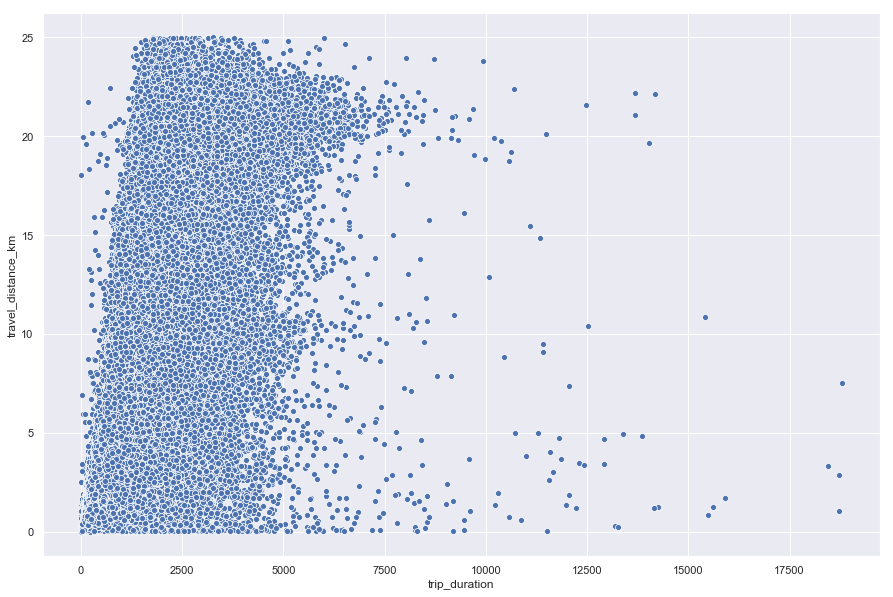

In [21]:
sns.scatterplot(
    x=df[(df['travel_distance_km'] > 0) & (df['travel_distance_km'] < 25) & (df['trip_duration'] < 20000)]['trip_duration'], 
    y=df[(df['travel_distance_km'] > 0) & (df['travel_distance_km'] < 25) & (df['trip_duration'] < 20000)]['travel_distance_km'])

The scatter plot shows the relationship between the distance and the time duration. We can see that there is a correlation between trip duration and distance. In other words, the further the distance the more time the taxi will take. 

The trip duration must have a correlation with traffic during peak hours so let's break down the hour and the day of the week in separate columns. 

In [39]:
df['hour_pickup'] = np.array(df['pickup_datetime'].dt.hour)
df['hour_dropoff'] = np.array(df['dropoff_datetime'].dt.hour)
df['day_pickup'] = np.array(df['pickup_datetime'].dt.day_name())
df['day_dropoff'] = np.array(df['dropoff_datetime'].dt.day_name())

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,travel_distance_km,day,hour_pickup,hour_dropoff,day_pickup,day_dropoff
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,1.498521,17,17,17,Monday,Monday
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,1.805507,0,0,0,Sunday,Sunday
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,6.385098,11,11,12,Tuesday,Tuesday
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,1.485498,19,19,19,Wednesday,Wednesday
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,1.188588,13,13,13,Saturday,Saturday
5,id0801584,2,2016-01-30 22:01:40,2016-01-30 22:09:03,6,-73.982857,40.742195,-73.992081,40.749184,N,443,1.098942,22,22,22,Saturday,Saturday
6,id1813257,1,2016-06-17 22:34:59,2016-06-17 22:40:40,4,-73.969017,40.757839,-73.957405,40.765896,N,341,1.326279,22,22,22,Friday,Friday
7,id1324603,2,2016-05-21 07:54:58,2016-05-21 08:20:49,1,-73.969276,40.797779,-73.922470,40.760559,N,1551,5.714981,7,7,8,Saturday,Saturday
8,id1301050,1,2016-05-27 23:12:23,2016-05-27 23:16:38,1,-73.999481,40.738400,-73.985786,40.732815,N,255,1.310353,23,23,23,Friday,Friday
9,id0012891,2,2016-03-10 21:45:01,2016-03-10 22:05:26,1,-73.981049,40.744339,-73.973000,40.789989,N,1225,5.121162,21,21,22,Thursday,Thursday


According to The New York Times, the peak hours of New York City is from 7 to 9 AM and from 4 to 6 PM. The histograms represent the ditribution of the trip duration during peak hours. 

Text(0.5, 1.0, 'log(Morning Peak Hours - Trip Duration)')

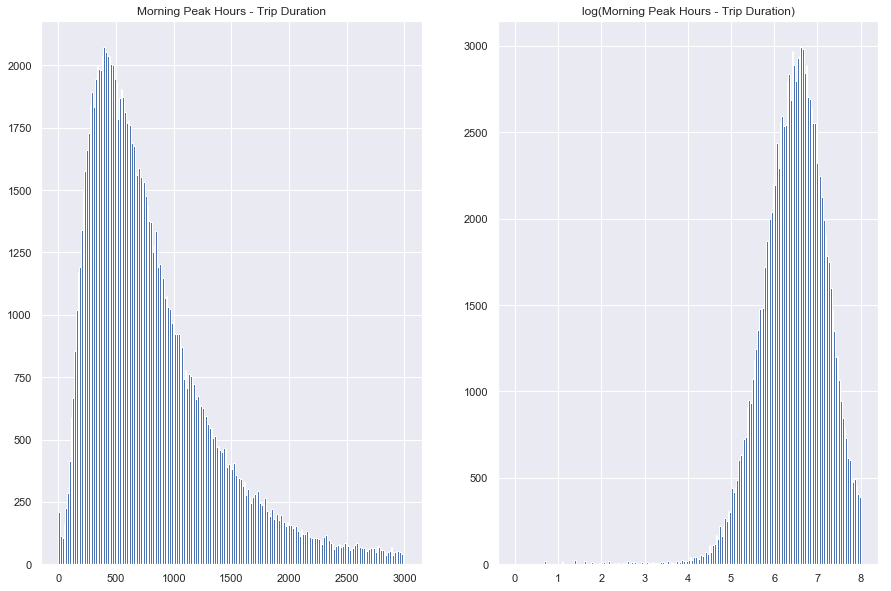

In [71]:

plt.subplot(1, 2, 1)
df[ 
    #Morning Peak Hours
    (
    (df['hour_pickup'] >= 7 ) & 
    (df['hour_pickup'] <= 9)   |
    
    (df['hour_dropoff'] >= 7 ) &
    (df['hour_dropoff'] <= 9) ) &
    
    #day fo the week
    ((df['day_pickup'] == 'Monday' )  |
    (df['day_pickup'] == 'Tuesday' )  |
    
    (df['day_pickup'] == 'Wednesday' )  |
    (df['day_pickup'] == 'Thusday' )  |
    (df['day_pickup'] == 'Friday' )  ) &
    
    (df['trip_duration'] < 3000)]['trip_duration'].hist(bins=200)

plt.title('Morning Peak Hours - Trip Duration')

plt.subplot(1, 2, 2)

np.log(df[ 
    #log(Morning Peak Hours)
    (
    (df['hour_pickup'] >= 7 ) & 
    (df['hour_pickup'] <= 9)   |
    
    (df['hour_dropoff'] >= 7 ) &
    (df['hour_dropoff'] <= 9) ) &
    
    #day fo the week
    ((df['day_pickup'] == 'Monday' )  |
    (df['day_pickup'] == 'Tuesday' )  |
    
    (df['day_pickup'] == 'Wednesday' )  |
    (df['day_pickup'] == 'Thusday' )  |
    (df['day_pickup'] == 'Friday' )  ) &
    
    (df['trip_duration'] < 3000)]['trip_duration']).hist(bins=200)

plt.title('log(Morning Peak Hours - Trip Duration)')



Text(0.5, 1.0, 'log(Afternoon Peak Hours - Trip Duration)')

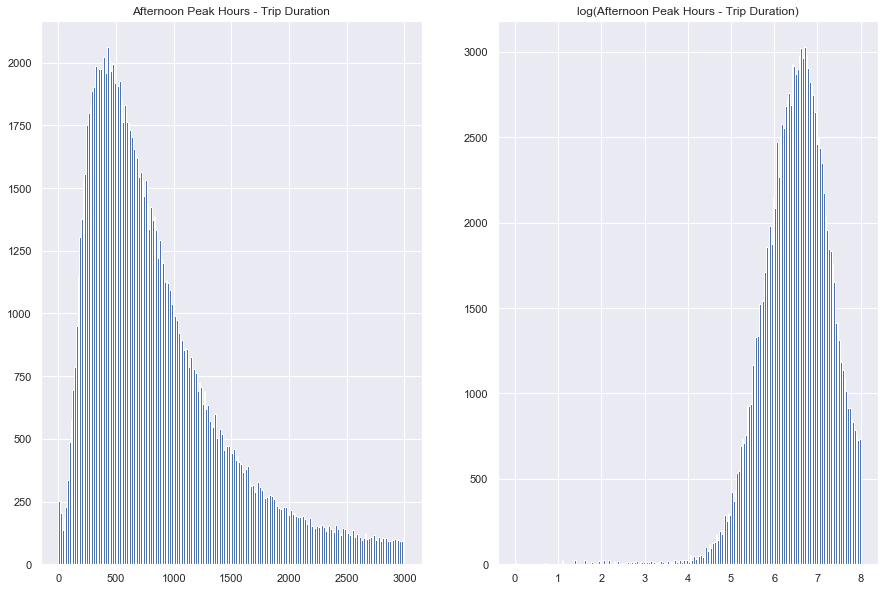

In [70]:

plt.subplot(1, 2, 1)
df[ 
    #Afternoon Peak Hours
    (
    (df['hour_pickup'] >= 16 ) & 
    (df['hour_pickup'] <= 18)   |
    
    (df['hour_dropoff'] >= 16 ) &
    (df['hour_dropoff'] <= 18) ) &
    
    #day fo the week
    ((df['day_pickup'] == 'Monday' )  |
    (df['day_pickup'] == 'Tuesday' )  |
    
    (df['day_pickup'] == 'Wednesday' )  |
    (df['day_pickup'] == 'Thusday' )  |
    (df['day_pickup'] == 'Friday' )  ) &
    
    (df['trip_duration'] < 3000)]['trip_duration'].hist(bins=200)

plt.title('Afternoon Peak Hours - Trip Duration')

plt.subplot(1, 2, 2)

np.log(df[ 
    #log(Afternoon Peak Hours)
    (
    (df['hour_pickup'] >= 16 ) & 
    (df['hour_pickup'] <= 18)   |
    
    (df['hour_dropoff'] >= 16 ) &
    (df['hour_dropoff'] <= 18) ) &
    
    #day fo the week
    ((df['day_pickup'] == 'Monday' )  |
    (df['day_pickup'] == 'Tuesday' )  |
    
    (df['day_pickup'] == 'Wednesday' )  |
    (df['day_pickup'] == 'Thusday' )  |
    (df['day_pickup'] == 'Friday' )  ) &
    
    (df['trip_duration'] < 3000)]['trip_duration']).hist(bins=200)

plt.title('log(Afternoon Peak Hours - Trip Duration)')


(0, 2000)

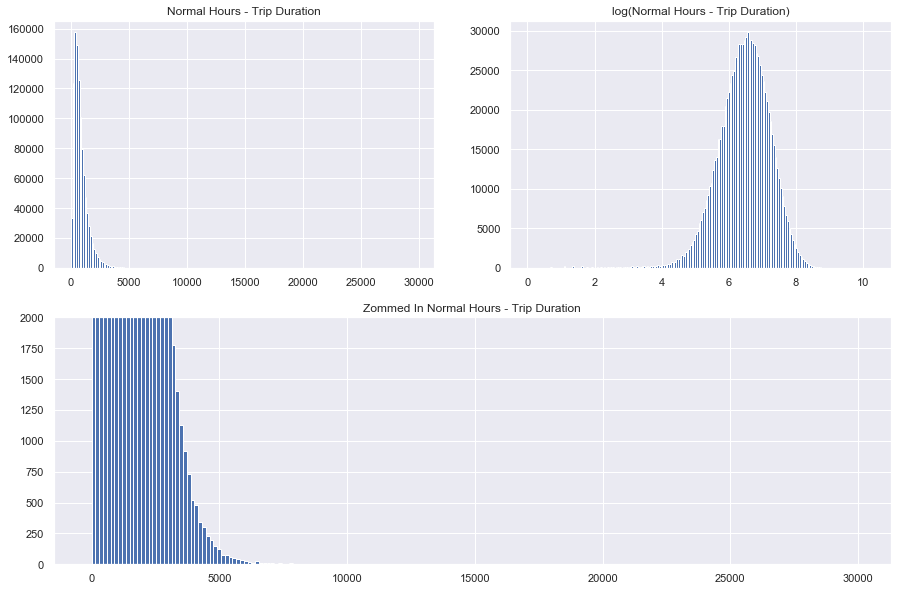

In [161]:
plt.subplot(221)
df[   
    
    #Normal hours
    
    ((df['hour_pickup'] < 7 ) |
    (df['hour_pickup'] > 9) )&
    
    (
    (df['hour_dropoff'] < 16 )  |             
    (df['hour_dropoff'] > 18))
    &
    (df['trip_duration'] < 30000)]['trip_duration'].hist(bins=200)

plt.title('Normal Hours - Trip Duration')
 

plt.subplot(222)
np.log(df[   
    
    #log(normal hours)
    
    ((df['hour_pickup'] < 7 ) |
    (df['hour_pickup'] > 9) )&
    
    (
    (df['hour_dropoff'] < 16 )  |             
    (df['hour_dropoff'] > 18))
    &
    (df['trip_duration'] < 30000)]['trip_duration']).hist(bins=200)

plt.title('log(Normal Hours - Trip Duration)')



plt.subplot(212)
df[   
    
    #Normal hours
    
    ((df['hour_pickup'] < 7 ) |
    (df['hour_pickup'] > 9) )&
    
    (
    (df['hour_dropoff'] < 16 )  |             
    (df['hour_dropoff'] > 18))
    &
    (df['trip_duration'] < 30000)]['trip_duration'].hist(bins=200)

plt.title('Zommed In Normal Hours - Trip Duration')
plt.ylim((0, 2000))


We can clearly see that trips during peak hours take longer then the trips during normal hours. In the Zoomed In histogram, there are very little trips that are longer than 10000 seconds. We can conclude that the data will help predict the trip duration therefore it is an important element of the dataset. 

In [379]:
df['day_pickup'] = df['day_pickup'].astype('category').cat.codes
df['store_and_fwd_flag'] = df['store_and_fwd_flag'].astype('category').cat.codes

df['log(trip_duration)'] = np.log(df['trip_duration'])

## Model Selection

In [411]:
X = df[['vendor_id','passenger_count', 
        'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag',
        'travel_distance_km', 'hour_pickup', 'hour_dropoff',
       'day_pickup']]

y = df['log(trip_duration)']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [412]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, random_state=42)

In [393]:
df.columns

Index(['id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime',
       'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag',
       'trip_duration', 'travel_distance_km', 'hour_pickup', 'hour_dropoff',
       'day_pickup', 'day_dropoff', 'log(trip_duration)'],
      dtype='object')

## Predictions

#### Linear Regression 

In [394]:
lr = LinearRegression()

In [395]:
lr.fit(X_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [396]:
pred = lr.predict(X_test)

Text(0.5, 1.0, 'Y_test - Predictions Distribution')

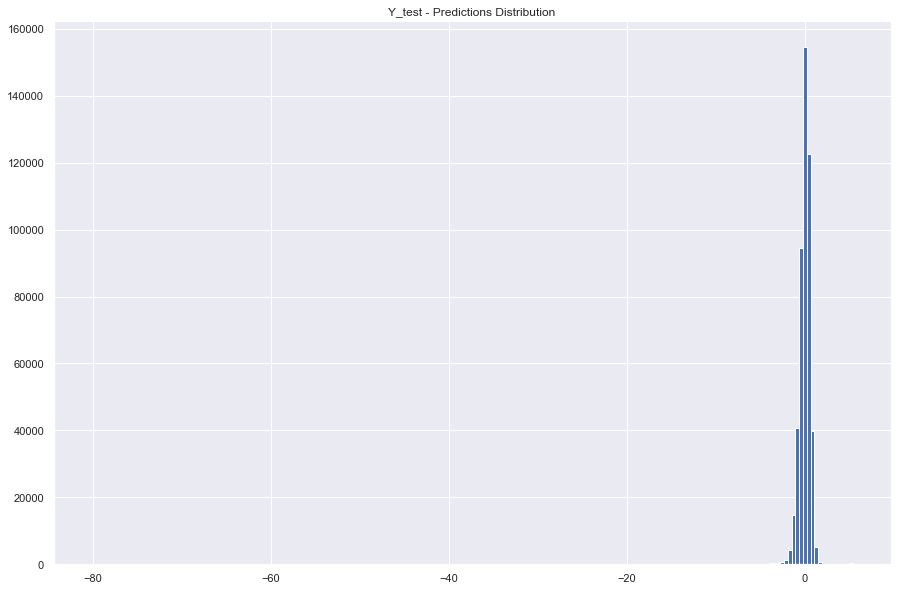

In [401]:
pd.DataFrame(np.array(y_test - pred)).hist(bins=200)
plt.title('Y_test - Predictions Distribution')


In [402]:
print('MAE: ',mean_absolute_error(y_test, pred))
print('MSE: ',mean_squared_error(y_test, pred))
print('RMSE: ',np.sqrt(mean_squared_error(y_test, pred))) 

MAE:  0.44927364269250397
MSE:  0.4106066281988091
RMSE:  0.640785945693887


In [403]:
df_coeff_lr = pd.DataFrame(lr.coef_, index= ['vendor_id','passenger_count', 'pickup_longitude', 'pickup_latitude','dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag','travel_distance_km', 'hour_pickup', 'hour_dropoff',
'day_pickup'], columns=['coef_'])
    
print(df_coeff_lr)
print('\n')
print('y intercept: ', lr.intercept_)

                       coef_
vendor_id           0.020406
passenger_count     0.006554
pickup_longitude   -1.378105
pickup_latitude     2.056878
dropoff_longitude   1.102135
dropoff_latitude   -2.010836
store_and_fwd_flag  0.000439
travel_distance_km  0.115813
hour_pickup         0.000462
hour_dropoff        0.006382
day_pickup          0.010556


y intercept:  -16.39021214382845


#### KNeighborsRegressor

In [419]:
rmse = []

def func(num): 
    knn = KNeighborsRegressor(n_neighbors=num)
    knn.fit(X_train, y_train)
    pred = knn.predict(X_valid)
    rmse.append(np.sqrt(mean_absolute_error(y_valid, pred)))

In [420]:
from threading import Thread

if __name__ == '__main__':
    Thread(target = func(10)).start()
    Thread(target = func(15)).start()
    Thread(target = func(20)).start()

In [421]:
if __name__ == '__main__':
    Thread(target = func(25)).start()
    Thread(target = func(30)).start()
    Thread(target = func(35)).start()

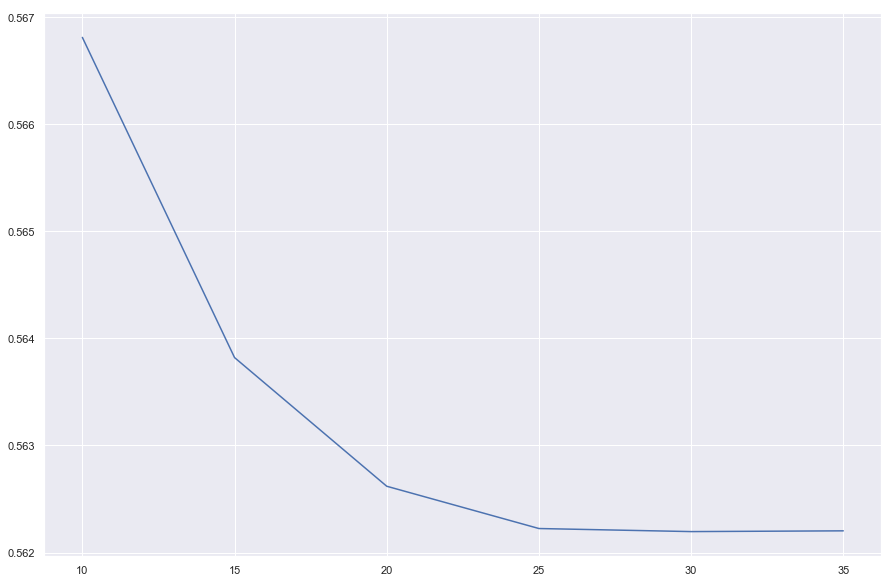

In [422]:
sns.lineplot(y=rmse, x=[10,15,20,25,30,35], markers=True)

The number of neighbors with the lowest RMSE: 35.

In [449]:
knn = KNeighborsRegressor(n_neighbors=35)
knn.fit(X_train, y_train)
pred = knn.predict(X_valid)
score_knn = cross_val_score(knn, X_train, y_train, cv=5, scoring='neg_mean_squared_log_error')

In [450]:
print('cross_val_score average: ', abs(np.mean(score_knn)))
print('MAE: ',mean_absolute_error(y_valid, pred))
print('MSE: ',mean_squared_error(y_valid, pred))
print('RMSE: ',np.sqrt(mean_squared_error(y_valid, pred))) 

cross_val_score average:  0.004995723794755478
MAE:  0.3160637253870264
MSE:  0.21791341379705884
RMSE:  0.46681196835241795
